# Physical Informed Neural Network : 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2 dimensions (x, y) : 

In [12]:
# PINN model (2D: x,y,t -> u) 
class PINN_2D(nn.Module):
    def __init__(self, width=128, depth=8):
        super().__init__()
        layers = []

        # input (x, y, t) -> R^3
        layers += [nn.Linear(3, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t):
        X = torch.stack((x, y, t), dim=-1)  
        u = self.net(X)                     
        return u.squeeze(-1)              


def grad_2D(u, x):
    return torch.autograd.grad(
        outputs=u,
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
    )[0]

def laplacian_2D(u, x, y):
    ux = grad_2D(u, x)
    uxx = grad_2D(ux, x)
    uy = grad_2D(u, y)
    uyy = grad_2D(uy, y)
    return uxx + uyy


def residual_2D(model, x, y, t, c, alpha, f_fn):
    # x,y,t must require grad for derivatives
    x = x.detach().requires_grad_(True)
    y = y.detach().requires_grad_(True)
    t = t.detach().requires_grad_(True)

    u = model(x, y, t)
    ut = grad_2D(u, t)
    utt = grad_2D(ut, t)
    lap = laplacian_2D(u, x, y)
    f = f_fn(x, y, t) 
    R = utt - c * lap + alpha * ut - f
    return R, u, ut



def f_fn(x, y, t, A=5, beta=200, t0=0.2, xs=0, ys=0, gamma=200):
    time_envelope = A * torch.exp(-beta * (t - t0)**2)
    spatial_envelope = torch.exp(-gamma * ((x - xs)**2 + (y - ys)**2))
    return time_envelope * spatial_envelope


mse = nn.MSELoss()

def loss_pinn_2D(model,
              x_p, y_p, t_p,          
              x_0, y_0, u0, v0,       
              x_b, y_b, t_b, g,      
              c, alpha, f_fn,
              w_phys=1, w_ic=10, w_bc=10):

    # physics residual
    R, _, _ = residual_2D(model, x_p, y_p, t_p, c, alpha, f_fn)
    L_phys = torch.mean(R**2)

    # initial displacement and velocity at t=0
    t0 = torch.zeros_like(x_0, requires_grad=True)
    u0_pred = model(x_0, y_0, t0)
    L_u0 = mse(u0_pred, u0)

    ut0_pred = grad_2D(u0_pred, t0)
    L_v0 = mse(ut0_pred, v0)

    # boundary (Dirichlet)
    u_b = model(x_b, y_b, t_b)
    L_bc = mse(u_b, g)

    L = w_phys * L_phys + w_ic * (L_u0 + L_v0) + w_bc * L_bc
    return L, L_phys.detach(), (L_u0 + L_v0).detach(), L_bc.detach()


# Training loop function
def train_2D(x_p, y_p, t_p,
          x_0, y_0, u0, v0,
          x_b, y_b, t_b, g,
          c, alpha):
    
    model = PINN_2D(width=128, depth=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    runs = 200#10000
    for it in range(runs + 1):
        optimizer.zero_grad()
        L, Lp, Lic, Lbc = loss_pinn_2D(
            model,
            x_p, y_p, t_p,
            x_0, y_0, u0, v0,
            x_b, y_b, t_b, g,
            c, alpha, f_fn,
            w_phys=1, w_ic=10, w_bc=10
        )
        L.backward()
        optimizer.step()

        if it % 1000 == 0:
            print(f"{it:05d}  total={L.item():.3e}  phys={Lp.item():.3e}  ic={Lic.item():.3e}  bc={Lbc.item():.3e}")
    return model

In [13]:
# Limits of the domain
x_min, x_max = -1, 1
y_min, y_max = -1, 1
t_min, t_max =  0, 1

c = torch.tensor(1, device=device)
alpha = torch.tensor(0, device=device)  

# collocation (physics)
N_phys = 2000
x_p = torch.empty(N_phys, device=device).uniform_(x_min, x_max)
y_p = torch.empty(N_phys, device=device).uniform_(y_min, y_max)
t_p = torch.empty(N_phys, device=device).uniform_(t_min, t_max)

# initial condition (t=0)
N_ic = 500
x_0 = torch.empty(N_ic, device=device).uniform_(x_min, x_max)
y_0 = torch.empty(N_ic, device=device).uniform_(y_min, y_max)
u0 = torch.exp(-5 * (x_0**2 + y_0**2))
v0 = torch.zeros_like(x_0)

# boundary 
# Left - Right
N_bc = 500
nb1 = N_bc // 2
t_b1 = torch.empty(nb1, device=device).uniform_(t_min, t_max)
y_b1 = torch.empty(nb1, device=device).uniform_(y_min, y_max)
x_left  = torch.full((nb1 // 2,), x_min, device=device)
x_right = torch.full((nb1 - nb1 // 2,), x_max, device=device)
x_b1 = torch.cat([x_left, x_right], dim=0)

# Top - Bottom
nb2 = N_bc - nb1
t_b2 = torch.empty(nb2, device=device).uniform_(t_min, t_max)
x_b2 = torch.empty(nb2, device=device).uniform_(x_min, x_max)
y_bottom = torch.full((nb2 // 2,), y_min, device=device)
y_top = torch.full((nb2 - nb2 // 2,), y_max, device=device)
y_b2 = torch.cat([y_bottom, y_top], dim=0)

x_b = torch.cat([x_b1, x_b2], dim=0)
y_b = torch.cat([y_b1, y_b2], dim=0)
t_b = torch.cat([t_b1, t_b2], dim=0)
g = torch.zeros_like(x_b)


In [14]:
model = train_2D(x_p, y_p, t_p,
      x_0, y_0, u0, v0,
      x_b, y_b, t_b, g,
      c, alpha)

00000  total=7.291e-01  phys=7.633e-04  ic=6.518e-02  bc=7.654e-03


In [15]:
# Function to compute reference solution using finite differences (Chat GPT was used to generate this code)
def source(X, Y, t, A=5, beta=200, t0=0.2, xs=0, ys=0, gamma=200):
    # time envelope (scalar)
    time = A * np.exp(-beta * (t - t0)**2)
    # space envelope (array same shape as X,Y)
    space = np.exp(-gamma * ((X - xs)**2 + (Y - ys)**2))
    return time * space

def fd_wave_2d(u0_fn, c, x_min, x_max, y_min, y_max, T, 
               Nx=101, Ny=101, Nt=200):
    """
    Explicit 2D wave solver with 5-point Laplacian, Dirichlet u=0 boundary, v0=0.
    Returns u_fd of shape (Nt, Nx, Ny).
    """
    x = np.linspace(x_min, x_max, Nx)
    y = np.linspace(y_min, y_max, Ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    assert abs(dx - dy) < 1e-12, "use equal spacing for simplicity"
    h = dx

    dt = T / (Nt - 1)
    # CFL stability for 2D wave: c*dt/h <= 1/sqrt(2)
    assert c * dt / h <= 1/np.sqrt(2) + 1e-12, "reduce dt or increase Nt"

    # allocate
    u_fd = np.zeros((Nt, Nx, Ny), dtype=np.float64)

    # initial condition u(x,y,0)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_fd[0] = u0_fn(X, Y)

    # --- one-sided step for n=1 using v0=0 and f=0 ---
    u0 = u_fd[0]
    lap0 = np.zeros_like(u0)
    lap0[1:-1, 1:-1] = (
        u0[2:,   1:-1] +
        u0[0:-2, 1:-1] +
        u0[1:-1, 2:  ] +
        u0[1:-1, 0:-2] -
        4 * u0[1:-1, 1:-1]
    ) / h**2

    # u_fd[1] = u_fd[0] + 0.5 * (c * dt)**2 * lap0
    u_fd[1] = u_fd[0] + 0.5 * (c * dt)**2 * lap0 + 0.5 * (dt**2) * source(X, Y, 0)

    # enforce Dirichlet boundary u=0 at n=0 and n=1
    for n in [0, 1]:
        u_fd[n, 0,   :] = 0
        u_fd[n, -1,  :] = 0
        u_fd[n, :,   0] = 0
        u_fd[n, :,  -1] = 0

    # --- time stepping ---
    for n in range(1, Nt - 1):
        u = u_fd[n]
        u_prev = u_fd[n - 1]

        lap = np.zeros_like(u)
        lap[1:-1, 1:-1] = (
            u[2:,   1:-1] +
            u[0:-2, 1:-1] +
            u[1:-1, 2:  ] +
            u[1:-1, 0:-2] -
            4 * u[1:-1, 1:-1]
        ) / h**2

        u_next = np.zeros_like(u)
        u_next[1:-1, 1:-1] = (
            2 * u[1:-1, 1:-1]
            - u_prev[1:-1, 1:-1]
            + (c * dt)**2 * lap[1:-1, 1:-1]
        )

        t_n = n * dt
        u_next[1:-1, 1:-1] += dt**2 * source(X[1:-1,1:-1], Y[1:-1,1:-1], t_n)

        # Dirichlet boundary
        u_next[0,   :] = 0
        u_next[-1,  :] = 0
        u_next[:,   0] = 0
        u_next[:,  -1] = 0

        u_fd[n + 1] = u_next

    return x, y, np.linspace(0, T, Nt), u_fd



def u0_fn_np(X, Y):
    return np.exp(-5*(X**2 + Y**2))

c_val = 1
T = 1
x, y, t_grid, u_fd = fd_wave_2d(u0_fn_np, c_val,
                                x_min, x_max, y_min, y_max,
                                T, Nx=101, Ny=101, Nt=201)

In [16]:
model.eval()

Nx, Ny, Nt = u_fd.shape[1], u_fd.shape[2], u_fd.shape[0] # Number of points in x,y,t

x_torch = torch.tensor(x, dtype=torch.float32, device=device) # Convert to torch tensors
y_torch = torch.tensor(y, dtype=torch.float32, device=device)
X_torch, Y_torch = torch.meshgrid(x_torch, y_torch, indexing='ij')  # Matrices of dimension : (Nx,Ny)

# Evaluate at final time step
k = -1  # last time step
t_val = float(t_grid[k])
T_torch = torch.full_like(X_torch, t_val, dtype=torch.float32, device=device) # Matrix (Nx,Ny) with time t_val

with torch.no_grad():  # Disables gradient computation -> faster
    # Flatten inputs for the model
    x_in = X_torch.reshape(-1)
    y_in = Y_torch.reshape(-1)
    t_in = T_torch.reshape(-1)

    # Reshape output back to grid
    u_pinn_flat = model(x_in, y_in, t_in)
    u_pinn_grid = u_pinn_flat.reshape(Nx, Ny).cpu().numpy()

u_fd_grid = u_fd[k]  # Extract the finite-difference (FD) solution
print("t =", t_val, " L2 error =", np.sqrt(np.mean((u_pinn_grid - u_fd_grid)**2)), "  max error =", np.max(np.abs(u_pinn_grid - u_fd_grid)))

t = 1.0  L2 error = 0.08804508682341655   max error = 0.1678014914204791


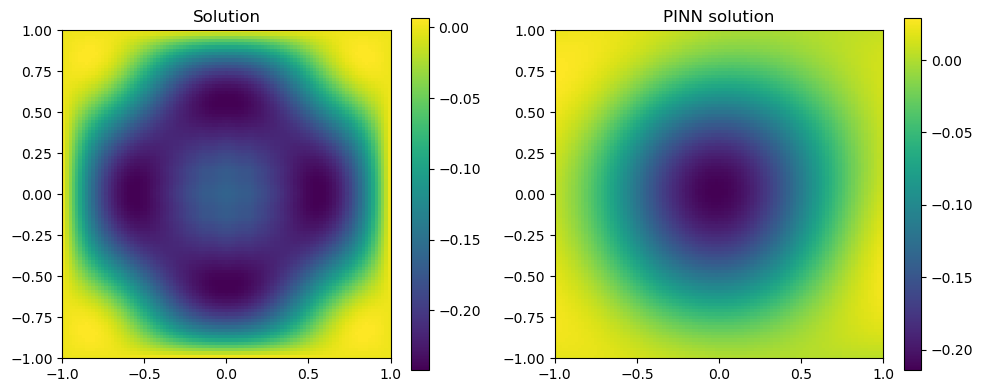

In [17]:
# Plot solutions (Chat GPT was used to generate this code)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Solution")
plt.imshow(u_fd_grid.T, origin='lower',
           extent=[x_min,x_max,y_min,y_max], aspect='equal')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PINN solution")
plt.imshow(u_pinn_grid.T, origin='lower',
           extent=[x_min,x_max,y_min,y_max], aspect='equal')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3 dimensions (x, y, z) : 

In [2]:

class PINN_3D(nn.Module):
    def __init__(self, width=128, depth=8):
        super().__init__()
        layers = []

        # input: (x, y, z, t) -> R^4
        layers += [nn.Linear(4, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]

        self.net = nn.Sequential(*layers)

    def forward(self, x, y, z, t):
        # x, y, t: tensors of same shape (...,)
        X = torch.stack((x, y, z,t), dim=-1)  # (..., 3)
        u = self.net(X)                     # (..., 1)
        return u.squeeze(-1)                # (...,)

In [3]:
def grad_3D(u, x):
    return torch.autograd.grad(
        outputs=u,
        inputs=x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
    )[0]

def laplacian_3D(u, x, y, z):
    ux = grad_3D(u, x)
    uxx = grad_3D(ux, x)
    uy = grad_3D(u, y)
    uyy = grad_3D(uy, y)
    uz = grad_3D(u, z)
    uzz = grad_3D(uz, z)
    return uxx + uyy + uzz

def residual_3D(model, x, y, z, t, c, alpha, f_fn):
    x = x.detach().requires_grad_(True)
    y = y.detach().requires_grad_(True)
    z = z.detach().requires_grad_(True)
    t = t.detach().requires_grad_(True)

    u = model(x, y, z, t)    
    ut = grad_3D(u, t)
    utt = grad_3D(ut, t)
    lap = laplacian_3D(u, x, y, z)
    f = f_fn(x, y, z, t)   

    R = utt - c * lap + alpha * ut - f
    return R, u, ut

def f_fn(x, y, z, t):
    return torch.zeros_like(x)

In [4]:
mse = nn.MSELoss()

def loss_pinn_3D(model,
              x_p, y_p, z_p, t_p,
              x_0, y_0, z_0, u0, v0,
              x_b, y_b, z_b, t_b, g,
              c, alpha, f_fn,
              w_phys=1.0, w_ic=10.0, w_bc=10.0):

    # physics residual
    R, _, _ = residual_3D(model, x_p, y_p, z_p, t_p, c, alpha, f_fn)
    L_phys = torch.mean(R**2)

    # initial displacement and velocity
    t0 = torch.zeros_like(x_0, requires_grad=True)
    u0_pred = model(x_0, y_0, z_0, t0)
    L_u0 = mse(u0_pred, u0)

    ut0_pred = grad_3D(u0_pred, t0)
    L_v0 = mse(ut0_pred, v0)

    # boundary (Dirichlet)
    u_b = model(x_b, y_b, z_b, t_b)
    L_bc = mse(u_b, g)

    L = w_phys * L_phys + w_ic * (L_u0 + L_v0) + w_bc * L_bc
    return L, L_phys.detach(), (L_u0 + L_v0).detach(), L_bc.detach()

### Test :

In [5]:
# Grid and time setup
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0
z_min, z_max = -1.0, 1.0 
t_min, t_max =  0.0, 1.0 

# Physical parameters
c = torch.tensor(1.0, device=device) 
alpha = torch.tensor(0.1, device=device)

# Collection points
N_phys = 5000
x_p = torch.empty(N_phys, device=device).uniform_(x_min, x_max)
y_p = torch.empty(N_phys, device=device).uniform_(y_min, y_max)
z_p = torch.empty(N_phys, device=device).uniform_(z_min, z_max)
t_p = torch.empty(N_phys, device=device).uniform_(t_min, t_max)

# Initial condition
N_ic = 200
x_0 = torch.empty(N_ic, device=device).uniform_(x_min, x_max)
y_0 = torch.empty(N_ic, device=device).uniform_(y_min, y_max)
z_0 = torch.empty(N_ic, device=device).uniform_(z_min, z_max)
u0 = torch.exp(-5.0 * (x_0**2 + y_0**2 + z_0**2))
v0 = torch.zeros_like(x_0) # zero belocity

# Boundary points (u = 0 on boundary)
# Width
nb_x = 200
t_bx = torch.empty(nb_x, device=device).uniform_(t_min, t_max)
y_bx = torch.empty(nb_x, device=device).uniform_(y_min, y_max)
z_bx = torch.empty(nb_x, device=device).uniform_(z_min, z_max)

x_left  = torch.full((nb_x // 2,), x_min, device=device)
x_right = torch.full((nb_x - nb_x // 2,), x_max, device=device)
x_bx = torch.cat([x_left, x_right], dim=0)

# Height
nb_y = 200
t_by = torch.empty(nb_y, device=device).uniform_(t_min, t_max)
x_by = torch.empty(nb_y, device=device).uniform_(x_min, x_max)
z_by = torch.empty(nb_y, device=device).uniform_(z_min, z_max)

y_bottom = torch.full((nb_y // 2,), y_min, device=device)
y_top = torch.full((nb_y - nb_y // 2,), y_max, device=device)
y_by = torch.cat([y_bottom, y_top], dim=0)

# Depth
nb_z = 200
t_bz = torch.empty(nb_z, device=device).uniform_(t_min, t_max)
x_bz = torch.empty(nb_z, device=device).uniform_(x_min, x_max)
y_bz = torch.empty(nb_z, device=device).uniform_(y_min, y_max)

z_bottom = torch.full((nb_z // 2,), z_min, device=device)
z_top = torch.full((nb_z - nb_z // 2,), z_max, device=device)
z_bz = torch.cat([z_bottom, z_top], dim=0)

# Concatenate boundary points
x_b = torch.cat([x_bx, x_by, x_bz], dim=0)
y_b = torch.cat([y_bx, y_by, y_bz], dim=0)
z_b = torch.cat([z_bx, z_by, z_bz], dim=0)
t_b = torch.cat([t_bx, t_by, t_bz], dim=0)
g = torch.zeros_like(x_b)   # u = 0 on boundary

In [10]:
def train_3D():
    model = PINN_3D(width=128, depth=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    runs = 200# 20000

    for it in range(runs + 1):
        optimizer.zero_grad()
        L, Lp, Lic, Lbc = loss_pinn_3D(
            model,
            x_p, y_p, z_p, t_p, 
            x_0, y_0, z_0, u0, v0,
            x_b, y_b, z_b, t_b, g,
            c, alpha, f_fn,
            w_phys=1.0, w_ic=10.0, w_bc=10.0
        )
        L.backward()
        optimizer.step()

        if it % 1000 == 0:
            print(f"{it:05d}  total={L.item():.3e}  phys={Lp.item():.3e}  ic={Lic.item():.3e}  bc={Lbc.item():.3e}")
    return model

00000  total=1.548e-01  phys=6.289e-06  ic=1.537e-02  bc=1.106e-04


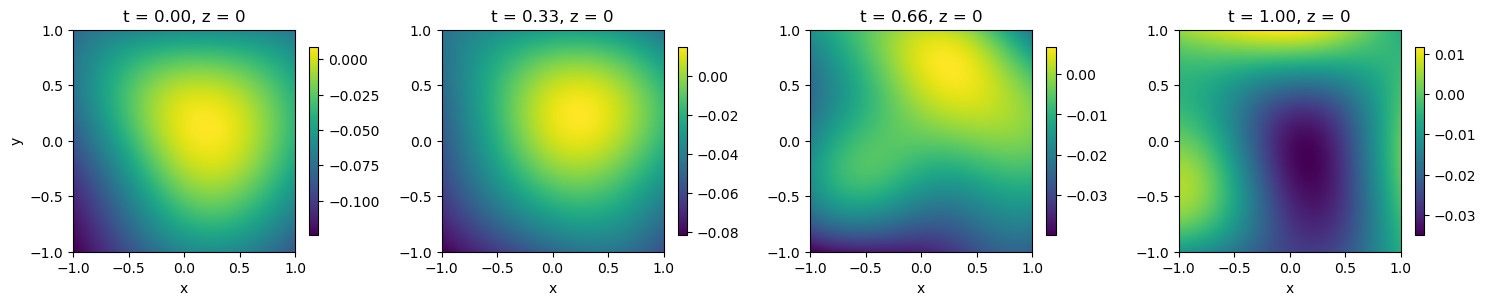

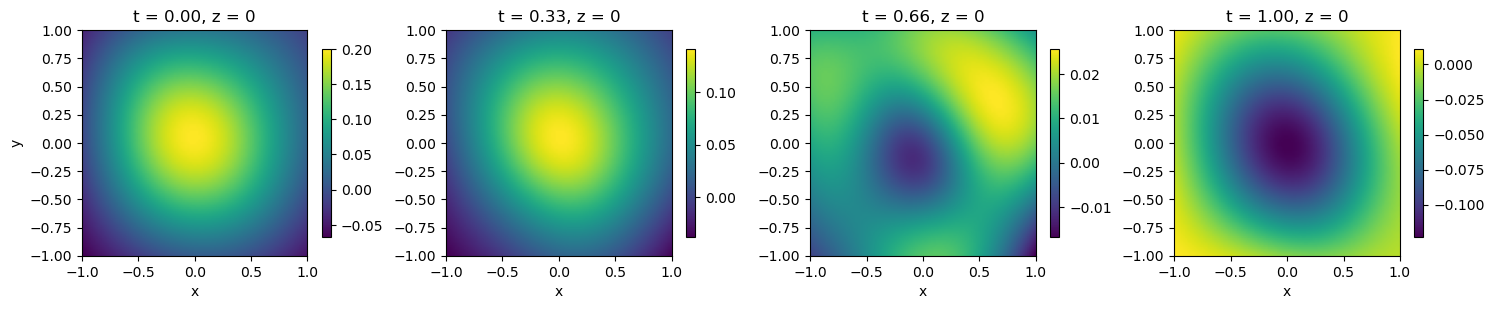

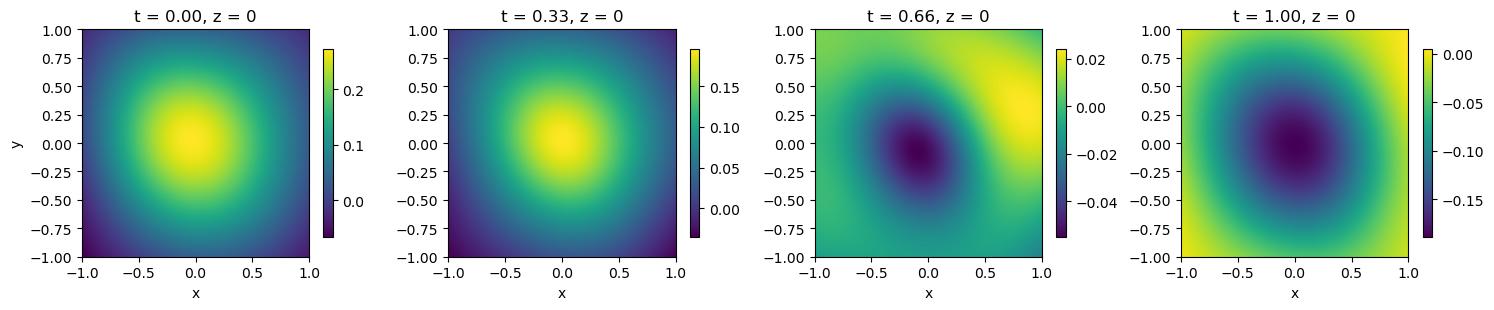

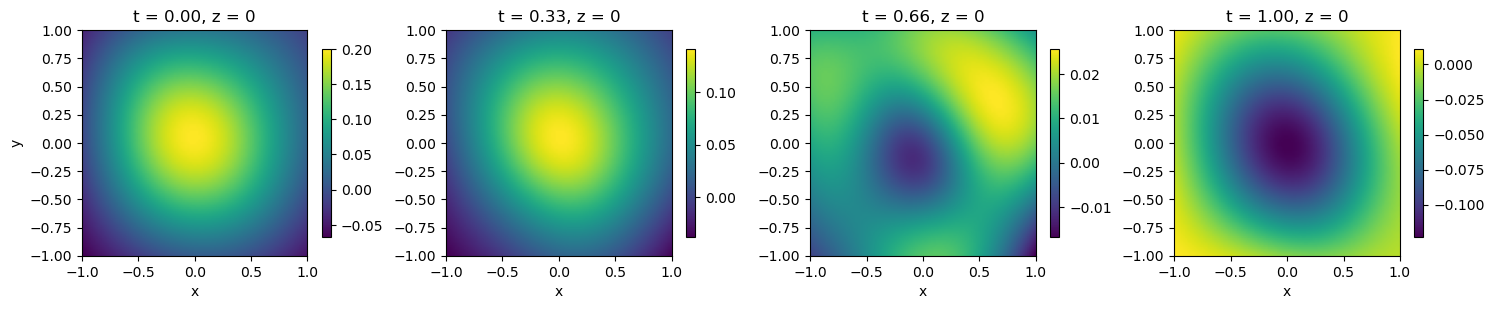

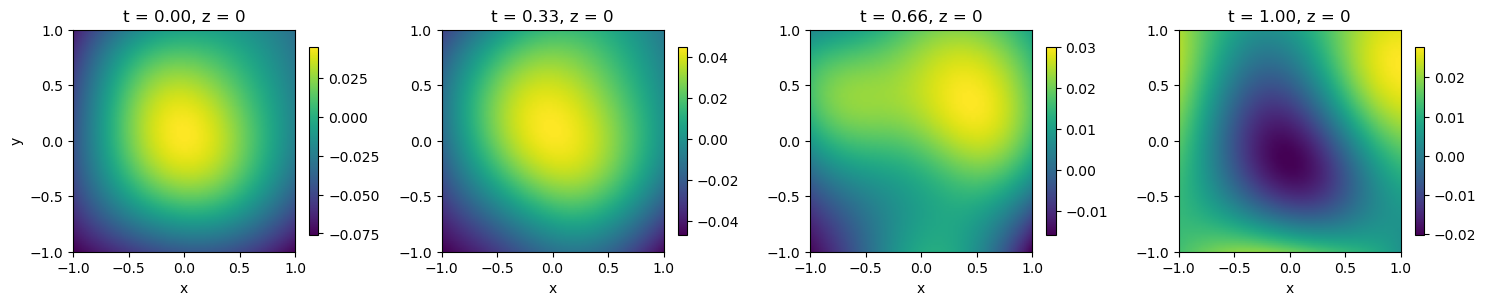

In [11]:
model = train_3D()
model.eval()

# ---- grid definition ----
Nx, Ny = 101, 101
x_lin = torch.linspace(x_min, x_max, Nx, device=device)
y_lin = torch.linspace(y_min, y_max, Ny, device=device)
X, Y = torch.meshgrid(x_lin, y_lin, indexing='ij')

# FIXED SLICE IN Z

for z_slice in [-1,0.5, 0, 0.5,1]:
# z_slice = 0.0
    Z = torch.full_like(X, z_slice)

    # times to visualize
    times_to_plot = [0.0, 0.33, 0.66, 1.0]

    plt.figure(figsize=(15, 3))

    with torch.no_grad():
        for i, t_val in enumerate(times_to_plot, start=1):

            T = torch.full_like(X, float(t_val))

            # flatten inputs for model
            x_in = X.reshape(-1)
            y_in = Y.reshape(-1)
            z_in = Z.reshape(-1)      # NEW
            t_in = T.reshape(-1)

            # evaluate 3D PINN
            u_flat = model(x_in, y_in, z_in, t_in)       # (Nx*Ny,)
            u_grid = u_flat.reshape(Nx, Ny).cpu().numpy()

            # Plot slice
            ax = plt.subplot(1, len(times_to_plot), i)
            im = ax.imshow(
                u_grid.T,
                origin='lower',
                extent=[x_min, x_max, y_min, y_max],
                aspect='equal'
            )
            ax.set_title(f"t = {t_val:.2f}, z = 0")
            ax.set_xlabel("x")
            if i == 1:
                ax.set_ylabel("y")

            plt.colorbar(im, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()